In [ ]:
import pandas as pd


df = pd.read_csv("/content/urldata.csv")


if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])


df['url']   = df['url'].astype(str).str.strip()
df['label'] = df['label'].astype(str).str.strip().str.lower()

expected = {'benign': 0, 'malicious': 1}
mismatch = (df['label'].map(expected) != df['result']).sum()
if mismatch > 0:
    df.loc[:, 'label'] = df['result'].map({0:'benign', 1:'malicious'})


df = (df[['url','label','result']]
      .dropna()
      .drop_duplicates(subset=['url'])
      .rename(columns={'result':'y'}))

print("Shape:", df.shape)
print("Clases:", df['y'].value_counts().to_dict())


Shape: (450176, 3)
Clases: {0: 345738, 1: 104438}


In [ ]:
RNG = 42
TARGET_PER_CLASS = 25_000

n_pos_av = int((df['y']==1).sum())
n_neg_av = int((df['y']==0).sum())

n_pos = min(TARGET_PER_CLASS, n_pos_av)
n_neg = min(TARGET_PER_CLASS, n_neg_av)


df_pos = df[df['y']==1].sample(n=n_pos, random_state=RNG, replace=False)
df_neg = df[df['y']==0].sample(n=n_neg, random_state=RNG, replace=False)


df_balanced = (pd.concat([df_pos, df_neg], axis=0)
                 .sample(frac=1.0, random_state=RNG)
                 .reset_index(drop=True))

print("Balanced shape:", df_balanced.shape)
print("Balanced counts:", df_balanced['y'].value_counts().to_dict())
df_balanced.head(3)


Balanced shape: (50000, 3)
Balanced counts: {0: 25000, 1: 25000}


,url,label,y
0,https://www.kxly.com/news/29009654/detail.html,benign,0
1,http://bethannesbest.com/wp-admin/user/dpbx,malicious,1
2,http://www.hebergement-discounter.com/gestion/...,malicious,1


In [ ]:

!pip -q install tldextract

import re, tldextract
from urllib.parse import urlsplit

def ensure_scheme(u: str) -> str:
    return u if str(u).startswith(('http://','https://')) else 'http://' + str(u)

def safe_urlsplit(u: str):
    """urlsplit que no revienta; devuelve (scheme, netloc, path, query)."""
    u2 = ensure_scheme(str(u).strip())
    try:
        p = urlsplit(u2)
        return p.scheme, p.netloc, p.path, p.query
    except Exception:
        # Fallback mínimo
        scheme = 'http'
        after = u2.split('://', 1)[-1]
        netloc = after.split('/', 1)[0].split('?', 1)[0].split('#', 1)[0]
        return scheme, netloc, '', ''

def registered_domain(u: str) -> str:
    """Devuelve dominio registrado; si falla, usa netloc."""
    try:
        ext = tldextract.extract(ensure_scheme(u))
        if ext.registered_domain:
            return ext.registered_domain
    except Exception:
        pass
    _, netloc, _, _ = safe_urlsplit(u)
    return netloc or 'unknown'


df_balanced['group'] = df_balanced['url'].apply(registered_domain)
print("Unique domains (balanced):", df_balanced['group'].nunique())
df_balanced.head(3)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.5 MB/s eta 0:00:00


/tmp/ipython-input-2282315579.py:27: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  if ext.registered_domain:
/tmp/ipython-input-2282315579.py:28: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  return ext.registered_domain


Unique domains (balanced): 26783


,url,label,y,group
0,https://www.kxly.com/news/29009654/detail.html,benign,0,kxly.com
1,http://bethannesbest.com/wp-admin/user/dpbx,malicious,1,bethannesbest.com
2,http://www.hebergement-discounter.com/gestion/...,malicious,1,hebergement-discounter.com


In [ ]:

!pip -q install tldextract

import re, tldextract
from urllib.parse import urlsplit

def ensure_scheme(u: str) -> str:
    return u if str(u).startswith(('http://','https://')) else 'http://' + str(u)

def safe_urlsplit(u: str):
    """urlsplit que no revienta; devuelve (scheme, netloc, path, query)."""
    u2 = ensure_scheme(str(u).strip())
    try:
        p = urlsplit(u2)
        return p.scheme, p.netloc, p.path, p.query
    except Exception:

        scheme = 'http'
        after = u2.split('://', 1)[-1]
        netloc = after.split('/', 1)[0].split('?', 1)[0].split('#', 1)[0]
        return scheme, netloc, '', ''

def registered_domain(u: str) -> str:
    """Devuelve dominio registrado; si falla, usa netloc."""
    try:
        ext = tldextract.extract(ensure_scheme(u))
        if ext.registered_domain:
            return ext.registered_domain
    except Exception:
        pass
    _, netloc, _, _ = safe_urlsplit(u)
    return netloc or 'unknown'


df_balanced['group'] = df_balanced['url'].apply(registered_domain)
print("Unique domains (balanced):", df_balanced['group'].nunique())
df_balanced.head(3)


/tmp/ipython-input-2282315579.py:27: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  if ext.registered_domain:
/tmp/ipython-input-2282315579.py:28: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  return ext.registered_domain


Unique domains (balanced): 26783


,url,label,y,group
0,https://www.kxly.com/news/29009654/detail.html,benign,0,kxly.com
1,http://bethannesbest.com/wp-admin/user/dpbx,malicious,1,bethannesbest.com
2,http://www.hebergement-discounter.com/gestion/...,malicious,1,hebergement-discounter.com


In [ ]:


import joblib
from datetime import datetime
import numpy as np, pandas as pd, re, tldextract
from urllib.parse import urlsplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


def ensure_scheme(u: str) -> str:
    return u if str(u).startswith(('http://','https://')) else 'http://' + str(u)

def safe_urlsplit(u: str):
    u2 = ensure_scheme(str(u).strip())
    try:
        p = urlsplit(u2)
        return p.scheme, p.netloc, p.path, p.query
    except Exception:
        scheme = 'http'
        after = u2.split('://', 1)[-1]
        netloc = after.split('/', 1)[0].split('?', 1)[0].split('#', 1)[0]
        return scheme, netloc, '', ''

# Suspicious tokens/tlds
SUS_KEYWORDS = [
    'login','verify','update','secure','bank','account','free','bonus',
    'confirm','urgent','signin','password','support','alert','invoice',
    'unlock','limited','gift','win','wallet','payment','reset'
]
SUS_TLDS = {'tk','ml','ga','cf','gq','xyz','top','icu','cn','ru'}
_ipv4_re = re.compile(r'^(?:\d{1,3}\.){3}\d{1,3}$')
_ipv6_loose_re = re.compile(r'^[\[\]0-9a-fA-F:]+$')

def has_ipv4(host: str) -> int:
    return int(bool(_ipv4_re.match(host)))

def has_ipv6_like(host: str) -> int:
    return int(':' in host and bool(_ipv6_loose_re.match(host)))

def lex_features(urls: pd.Series) -> pd.DataFrame:
    feats = {
        'url_len':[], 'host_len':[], 'path_len':[], 'query_len':[],
        'num_digits':[], 'digit_ratio':[], 'num_special':[], 'num_dots':[],
        'has_https':[], 'has_at':[], 'has_dash':[], 'has_ip4':[], 'has_ip6_like':[],
        'sus_kw':[], 'sus_tld':[]
    }
    for u in urls.astype(str):
        u_clean = ensure_scheme(u.strip().replace('\x00',''))
        try:
            p = urlsplit(u_clean)
            scheme, host, path, query = p.scheme, p.netloc, p.path, p.query
        except Exception:
            scheme, host, path, query = 'http', '', '', ''
        lower = u_clean.lower()

        digits   = sum(c.isdigit() for c in u_clean)
        specials = sum(u_clean.count(ch) for ch in ['@','-','_','?','=','&','%','/'])
        # safe TLD
        try:
            ext = tldextract.extract(u_clean)
            tld = (ext.suffix or '').lower()
        except Exception:
            tld = ''

        feats['url_len'].append(len(u_clean))
        feats['host_len'].append(len(host))
        feats['path_len'].append(len(path))
        feats['query_len'].append(len(query))
        feats['num_digits'].append(digits)
        feats['digit_ratio'].append(digits / max(1, len(u_clean)))
        feats['num_special'].append(specials)
        feats['num_dots'].append(u_clean.count('.'))
        feats['has_https'].append(int(scheme == 'https'))
        feats['has_at'].append(int('@' in lower))
        feats['has_dash'].append(int('-' in host))
        feats['has_ip4'].append(has_ipv4(host))
        feats['has_ip6_like'].append(has_ipv6_like(host))
        feats['sus_kw'].append(int(any(k in lower for k in SUS_KEYWORDS)))
        feats['sus_tld'].append(int(tld in SUS_TLDS))
    return pd.DataFrame(feats)


def lex_features_from_df(X: pd.DataFrame) -> pd.DataFrame:

    return lex_features(X['url'])

def pick_url(X: pd.DataFrame) -> pd.Series:

    return X['url'].astype(str)

num_transformer_final = FunctionTransformer(lex_features_from_df, validate=False)
char_ngrams_final = Pipeline([
    ('pick', FunctionTransformer(pick_url, validate=False)),
    ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2))
])
feats_union = FeatureUnion([
    ('num', num_transformer_final),
    ('char', char_ngrams_final)
])

print("feats_union rebuilt")

feats_union rebuilt ✅ | FAST


LR

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


X = df_balanced[['url']]
y = df_balanced['y'].values
groups = df_balanced['group'].values


N_FOLDS = 3
gkf = GroupKFold(n_splits=min(N_FOLDS, len(np.unique(groups))))


logreg = LogisticRegression(max_iter=1000, solver='liblinear',
                            class_weight='balanced', random_state=42)
pipe_logreg = Pipeline([('feats', feats_union), ('clf', logreg)])


oof_proba_lr = np.zeros_like(y, dtype=float)
oof_pred_lr  = np.zeros_like(y, dtype=int)
rows_lr = []

for i, (tr, te) in enumerate(gkf.split(X, y, groups)):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y[tr], y[te]

    pipe_logreg.fit(Xtr, ytr)
    proba = pipe_logreg.predict_proba(Xte)[:,1]
    pred  = (proba >= 0.5).astype(int)

    oof_proba_lr[te] = proba
    oof_pred_lr[te]  = pred

    prec = precision_score(yte, pred, zero_division=0)
    rec  = recall_score(yte, pred, zero_division=0)
    f1   = f1_score(yte, pred, zero_division=0)
    try:
        roc = roc_auc_score(yte, proba)
    except ValueError:
        roc = np.nan

    print(f"\n[LOGREG] Fold {i+1}/{gkf.n_splits} — "
          f"Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f} ROC-AUC={roc:.3f}")
    print("Confusion @0.5:\n", confusion_matrix(yte, pred))

    rows_lr.append({"fold": i+1, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc})

df_lr = pd.DataFrame(rows_lr)
print("\n== LOGREG per-fold averages ==")
print(df_lr.mean(numeric_only=True).round(3))


roc_full = roc_auc_score(y, oof_proba_lr)
pr_auc_full = average_precision_score(y, oof_proba_lr)
print(f"\n== LOGREG global OOF ==\nROC-AUC={roc_full:.3f} | PR-AUC={pr_auc_full:.3f}")
print("Global confusion @0.5:\n", confusion_matrix(y, oof_pred_lr))
print("\nGlobal classification @0.5:\n", classification_report(y, oof_pred_lr, digits=3))



[LOGREG] Fold 1/3 — Prec=1.000 Rec=0.943 F1=0.971 ROC-AUC=0.999
Confusion @0.5:
 [[8334    2]
 [ 473 7858]]

[LOGREG] Fold 2/3 — Prec=0.999 Rec=0.969 F1=0.984 ROC-AUC=0.999
Confusion @0.5:
 [[8388   12]
 [ 256 8011]]

[LOGREG] Fold 3/3 — Prec=1.000 Rec=0.964 F1=0.982 ROC-AUC=0.999
Confusion @0.5:
 [[8261    3]
 [ 301 8101]]

== LOGREG per-fold averages ==
fold         2.000
precision    0.999
recall       0.959
f1           0.979
roc_auc      0.999
dtype: float64

== LOGREG global OOF ==
ROC-AUC=0.999 | PR-AUC=0.999
Global confusion @0.5:
 [[24983    17]
 [ 1030 23970]]

Global classification @0.5:
               precision    recall  f1-score   support

           0      0.960     0.999     0.979     25000
           1      0.999     0.959     0.979     25000

    accuracy                          0.979     50000
   macro avg      0.980     0.979     0.979     50000
weighted avg      0.980     0.979     0.979     50000



RF

In [ ]:

import numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X = df_balanced[['url']]
y = df_balanced['y'].values
groups = df_balanced['group'].values


N_FOLDS = 3
gkf = GroupKFold(n_splits=min(N_FOLDS, len(np.unique(groups))))


rf = RandomForestClassifier(
    n_estimators=150,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

pipe_rf = Pipeline([('feats', feats_union), ('clf', rf)])


oof_proba_rf = np.zeros_like(y, dtype=float)
oof_pred_rf  = np.zeros_like(y, dtype=int)
rows_rf = []

for i, (tr, te) in enumerate(gkf.split(X, y, groups)):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y[tr], y[te]

    pipe_rf.fit(Xtr, ytr)
    proba = pipe_rf.predict_proba(Xte)[:,1]
    pred  = (proba >= 0.5).astype(int)


    oof_proba_rf[te] = proba
    oof_pred_rf[te]  = pred


    prec = precision_score(yte, pred, zero_division=0)
    rec  = recall_score(yte, pred, zero_division=0)
    f1   = f1_score(yte, pred, zero_division=0)
    try:
        roc = roc_auc_score(yte, proba)
    except ValueError:
        roc = np.nan

    print(f"\n[RF] Fold {i+1}/{gkf.n_splits} — "
          f"Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f} ROC-AUC={roc:.3f}")
    print("Confusion @0.5:\n", confusion_matrix(yte, pred))

    rows_rf.append({"fold": i+1, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc})


df_rf = pd.DataFrame(rows_rf)
print("\n== RF per-fold averages ==")
print(df_rf.mean(numeric_only=True).round(3))


roc_full_rf = roc_auc_score(y, oof_proba_rf)
pr_auc_full_rf = average_precision_score(y, oof_proba_rf)
print(f"\n== RF global OOF ==\nROC-AUC={roc_full_rf:.3f} | PR-AUC={pr_auc_full_rf:.3f}")
print("Global confusion @0.5:\n", confusion_matrix(y, oof_pred_rf))
print("\nGlobal classification @0.5:\n", classification_report(y, oof_pred_rf, digits=3))



[RF] Fold 1/3 — Prec=0.998 Rec=0.994 F1=0.996 ROC-AUC=0.999
Confusion @0.5:
 [[8317   19]
 [  51 8280]]

[RF] Fold 2/3 — Prec=0.998 Rec=0.995 F1=0.996 ROC-AUC=0.999
Confusion @0.5:
 [[8381   19]
 [  40 8227]]

[RF] Fold 3/3 — Prec=0.998 Rec=0.994 F1=0.996 ROC-AUC=0.999
Confusion @0.5:
 [[8247   17]
 [  53 8349]]

== RF per-fold averages ==
fold         2.000
precision    0.998
recall       0.994
f1           0.996
roc_auc      0.999
dtype: float64

== RF global OOF ==
ROC-AUC=0.999 | PR-AUC=0.999
Global confusion @0.5:
 [[24945    55]
 [  144 24856]]

Global classification @0.5:
               precision    recall  f1-score   support

           0      0.994     0.998     0.996     25000
           1      0.998     0.994     0.996     25000

    accuracy                          0.996     50000
   macro avg      0.996     0.996     0.996     50000
weighted avg      0.996     0.996     0.996     50000



In [ ]:


rf_final = RandomForestClassifier(
    n_estimators=400,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

final_pipe = Pipeline([('feats', feats_union), ('clf', rf_final)])


final_pipe.fit(df_balanced[['url']], df_balanced['y'])

# Export
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
MODEL_PATH = f"phishing_url_pipeline_rf_{ts}.joblib"
joblib.dump(final_pipe, MODEL_PATH)
print("Saved:", MODEL_PATH)


Saved: phishing_url_pipeline_rf_20251016_034222.joblib


In [ ]:
import pandas as pd

urls_to_check = [
    "http://secure-update-bank-login.net/reset",
    "https://www.paypal.com",
    "https://my.ucf.edu",
    "https://www.youtube.com",
    "br-icloud.com.br",
    "http://appleid.apple.com.verify-session-login.secure-apple.com.co"
]
proba = final_pipe.predict_proba(pd.DataFrame({'url': urls_to_check}))[:,1]
pred  = (proba >= 0.5).astype(int)
pd.DataFrame({'url': urls_to_check, 'proba': proba, 'pred@0.5': pred})


,url,proba,pred@0.5
0,http://secure-update-bank-login.net/reset,0.9975,1
1,https://www.paypal.com,0.4075,0
2,https://my.ucf.edu,0.9150,1
3,https://www.youtube.com,0.0375,0
4,br-icloud.com.br,0.9225,1
5,http://appleid.apple.com.verify-session-login....,0.9925,1


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)

def summarize_model(name, y_true, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    tn, fp, fn, tp = cm.ravel()
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)
    rep = classification_report(y_true, pred, digits=3, output_dict=True)
    summary = {
        "model": name,
        "threshold": thr,
        "ROC-AUC": roc,
        "PR-AUC": pr,
        "precision@thr": rep['1']['precision'],
        "recall@thr": rep['1']['recall'],
        "f1@thr": rep['1']['f1-score'],
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    }
    return pd.Series(summary), cm, rep

rows = []
rows_rf, cm_rf, rep_rf = summarize_model("RandomForest", y, oof_proba_rf, thr=0.5)
rows.append(rows_rf)


try:
    rows_lr, cm_lr, rep_lr = summarize_model("LogReg", y, oof_proba_lr, thr=0.5)
    rows.append(rows_lr)
except NameError:
    cm_lr = rep_lr = None

df_summary = pd.DataFrame(rows).set_index("model")
df_summary


,threshold,ROC-AUC,PR-AUC,precision@thr,recall@thr,f1@thr,TP,FP,FN,TN
model,,,,,,,,,,
RandomForest,0.5,0.999367,0.999496,0.997792,0.99424,0.996013,24856,55,144,24945
LogReg,0.5,0.998708,0.999017,0.999291,0.95880,0.978627,23970,17,1030,24983


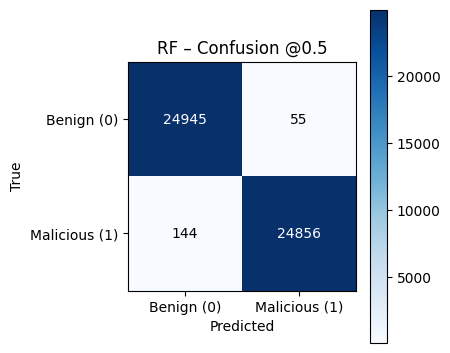

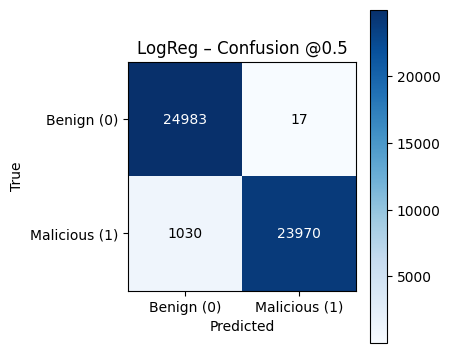

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cm(cm, title):
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign (0)','Malicious (1)'])
    plt.yticks(tick_marks, ['Benign (0)','Malicious (1)'])
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout(); plt.show()

plot_cm(cm_rf, "RF – Confusion @0.5")
try:
    plot_cm(cm_lr, "LogReg – Confusion @0.5")
except NameError:
    pass
